# DLSP25U: Introduction to Deep Learning

**Name:** Hailemariam


**Instructions:**

In this notebook, you will be asked to write code and answer questions.  
Place all responses under the **Solution** headers.

---

This second assignment is aimed at coding the soft perceptron algorithm. 
Hereafter we import some useful libraries and set the random seed for reproducibility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

SEED = 0
np.random.seed(SEED)

## The Soft Perceptron (binary)

The soft perceptron is a variant of the original perceptron in which the step function (or Heaviside function) is replaced with the sigmoid function, defined as:

$$
\sigma(s) = \frac{1}{1 + \exp(- s)}
$$

This has mutliple consequences, the most important being that the perceptron's output is no longer binary $\{0, 1\}$ but continuous in the range $(0, 1)$.

$$
\begin{align*}
    \text{Perceptron}_{\text{hard}} &: \mathbb{R}^N \to \{ 0, 1\} \\
    \text{Perceptron}_{\text{soft}} &: \mathbb{R}^N \to ( 0, 1 )
\end{align*}
$$

This allows us not only to classify the input data but also to provide a **level of confidence** in the classification. Points closer to the decision boundary will be less confidently classified than points further away.

More formally, we can describe the soft perceptron as the following (*discriminative*) model:

$$
\begin{align*}
    y &\sim \text{Bernoulli}(\tilde{y}) \\
    \tilde{y} &= \mathbb{P}(y = 1 \mid x) = \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x))
\end{align*}
$$
<!-- 
This means that for each input $x$, we can compute its probability to belong to class $1$ and then classify it based on a threshold  $\tau$. One could rewrite the above as:

$$
\hat{y} = \begin{cases}
    1 & \text{if } \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x)) \geq \tau \\
    0 & \text{otherwise}
\end{cases}
$$

or, using the Iverson bracket:

$$
\begin{align*}
    \hat{y} &= [ \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x)) \geq \tau ] \\
    &= \left[ \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x)) \geq \frac{1}{2} \right] \\
\end{align*}
$$

$\tau = \frac{1}{2}$ guarantees that the decision rule is equivalent to the one of the hard perceptron. -->

The update rule for the soft perceptron is the same as the original perceptron, hence:  
$$
\begin{equation*}
    \boldsymbol{w} \gets \boldsymbol{w} + (y - \tilde{y}) \boldsymbol{f}(x)
\end{equation*}
$$


The image below illustrates an example of a soft perceptron's output probability for study hours and exam pass probability.
<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Exam_pass_logistic_curve.svg/1280px-Exam_pass_logistic_curve.svg.png" alt="Image description" width=500 />
</p>



The soft perceptron gives us in output a probability of the input belonging to class $1$. Once we have the probability, how should we **decide** the class?
In the original, or "hard", perceptron we computed the decision boundary $\boldsymbol{w}^{\top} \boldsymbol{f}(x) = 0$ and classified the input based on the fact that the output was on the positive or negative side of the boundary. This can be seen as computing the value $\sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x))$ and comparing it to a threshold $\tau = 0$, if it is greater than the threshold we classify the input as $1$, otherwise as $0$.

The question is: 

to be consistent with the original perceptron, what should the threshold be for the soft perceptron?

**Solution**

The threshold for the soft perceptron is:

$$
\begin{align*}
    \boldsymbol{w}^{\top} \boldsymbol{f}(x) &= 0 \\
    \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x)) &= \sigma(0) \\
    \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x)) &= \frac{1}{2}
\end{align*}
$$

### Exercise 1 [4 Points]

The first exercise requires you to implement the soft perceptron algorithm using a Python class. Below is a template for the `SoftPerceptron` class. You need to implement the methods `train`, `predict`, and `decide`:

- The `train` method should implement the perceptron learning algorithm. It should take the training dataset as input and process all pairs \((x, y)\), updating the weights accordingly.  
- The `predict` method should take a data point `f` as input and return the predicted probability of the class \(y = 1\), i.e., \(\mathbb{P}(y = 1 \mid x)\).  
- The `decide` method should take a data point `f` as input and return the predicted label.  

In [97]:
class SoftPerceptron:
    def __init__(self, n_features):
        # You can either include the bias term in the weights vector or not
        # but consider adapting the predict method accordingly
        self.w = np.zeros(n_features)
        self.b = 0
        self.threshold = 0.5

    def predict(self, f):
        y = np.dot(self.w, f) + self.b

        return 1/(1+np.exp(-y))
    def decide(self, f):
        if(self.predict(f) > self.threshold):
            return 1
        else:
            return 0
        
    def train(self, F, y):
        for i in range(len(F)):
            self.w += (y[i] - (self.predict(F[i]))) * F[i]
            self.b += (y[i] - self.predict(F[i]))

### Data Generation

We will generate a dataset $D = \{ (x_n, y_n) \}_{n=1}^{N=500}$ where $\boldsymbol{f}(x_n) \in \mathbb{R}^2$ and $y_n \in \{0, 1\}$.
The dataset will be generated in the following way:
$$\boldsymbol{f}(x_n) \sim \begin{cases}
\mathcal{N}\left(\begin{pmatrix} 1 \\ 1\end{pmatrix}, \sigma^2 \mathbb{I}_2 \right) & \text{if } y_n = 1 \\
\mathcal{N}\left(\begin{pmatrix}-1 \\ -1\end{pmatrix}, \sigma^2 \mathbb{I}_2 \right) & \text{if } y_n = 0
\end{cases}
$$

The function `generate_dataset` does exactly this and you do not have to modify it.

In [3]:
def generate_dataset(
    n_samples = 1000,
    sigma = 1,
    mean = 1
):
    # Generate mean vectors
    mean_positive = np.array([mean, mean])
    mean_negative = np.array([-mean, -mean])

    # Generate covariance matrix
    covariance_matrix = sigma**2 * np.eye(2)

    # Generate labels
    y = np.random.choice([0, 1], size=n_samples)

    # Generate data points based on labels
    F = np.array([
        np.random.multivariate_normal(mean_positive, covariance_matrix) if label == 1 
        else np.random.multivariate_normal(mean_negative, covariance_matrix) 
        for label in y
    ])

    return F, y

[0.28765882 1.25432802] 1


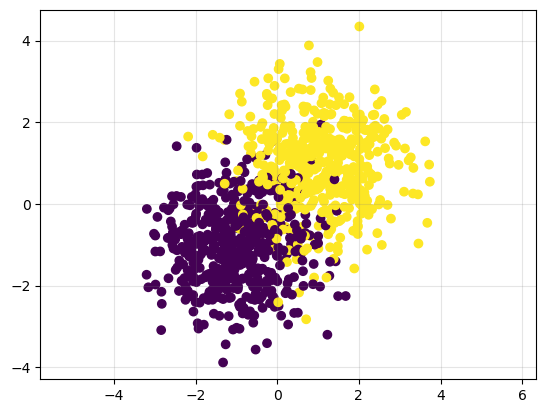

In [ ]:
F, y = generate_dataset()

plt.scatter(F[:, 0], F[:, 1], c=y)
plt.grid(c='.5', alpha=.2)
plt.axis('equal');

### Exercise 2 [2 Points]

Now you are asked to:
- Split the dataset into a training and a test set
- Train the soft perceptron on the training set
- Evaluate the accuracy of the model on both the training and test set

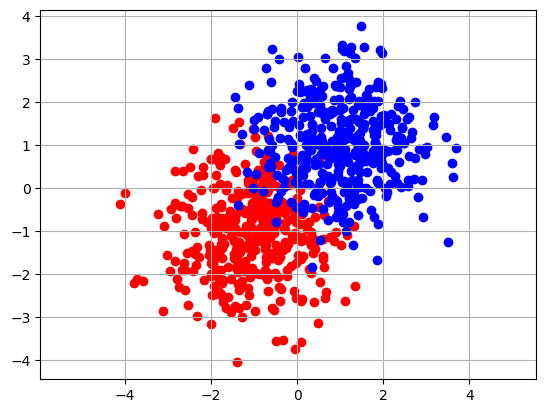

In [5]:
#TODO
F_train, F_test, y_train, y_test = train_test_split(
    F, y, test_size=0.2, random_state=42, stratify=y
)
myPerceptron = SoftPerceptron(2)
myPerceptron.train(F_train,y_train)
plt.scatter(F_train[y_train == 0][:, 0], F_train[y_train == 0][:, 1], color='red')
plt.scatter(F_train[y_train == 1][:, 0], F_train[y_train == 1][:, 1], color='blue')
plt.grid()
plt.axis('equal')
plt.show()



In [6]:
# Compute accuracy
from sklearn.metrics import accuracy_score
train_preds = [myPerceptron.decide(f) for f in F_train]
test_preds = [myPerceptron.decide(f) for f in F_test]
train_acc = accuracy_score(train_preds, y_train)
test_acc = accuracy_score(test_preds, y_test)

print(f"  Train accuracy: {train_acc}")
print(f"  Test accuracy : {test_acc}")
print(f"  Weights       : {myPerceptron.w}\n")

  Train accuracy: 0.92625
  Test accuracy : 0.935
  Weights       : [2.39327331 1.64984238]



### Exercise 3 [3 Points]

In the previous assignemnt, we have seen that visualizing the decision boundary of the hard perceptron was a useful way to understand how the model works.
Now, we would like to go further:
- Draw curves on the input space where the model predicts $y = 1$ with probabilities $0.1, 0.2, \dots, 0.9$.  
- Label these equal-probability curves with their respective probability values and shade the regions between them.  
- Answer the following questions:  
    - Are the equal-probability curves parallel? Why or why not?  
    - Are the shaded regions between the curves equally spaced? Why or why not?  


*Note: Since the soft perceptron is a linear model and the data lies in $\mathbb{R}^2$, both the decision boundary and the equal-probability curves are straight lines.*


**Useful functions for this exercise:**  
- `numpy.meshgrid`  
- `matplotlib.pyplot.contourf`  
- `matplotlib.pyplot.contour`  
- `matplotlib.pyplot.clabel`  

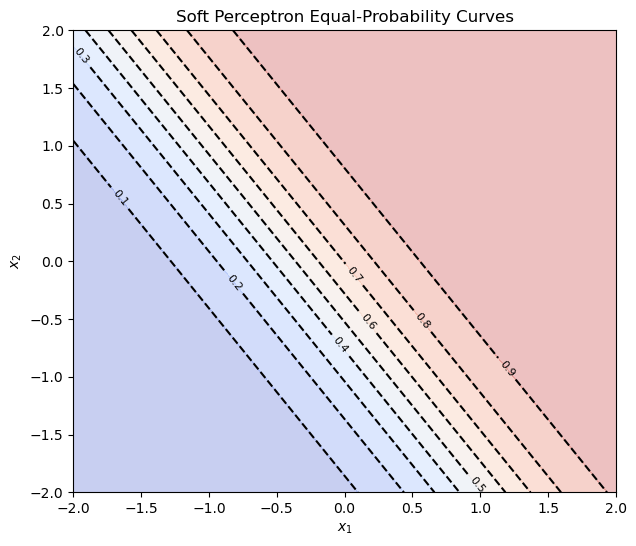

In [7]:
import matplotlib.pyplot as plt

w = myPerceptron.w  
b = myPerceptron.b                

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Generate a grid of points covering input space
x_min, x_max = -2, 2
y_min, y_max = -2, 2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Compute probabilities at each grid point
Z = sigmoid(w[0]*xx + w[1]*yy + b)

# Plot contour lines for probabilities 0.1 ... 0.9
plt.figure(figsize=(7,6))

# Shade the regions between the curves
shaded = plt.contourf(xx, yy, Z, levels=np.arange(0, 1.1, 0.1), alpha=0.3, cmap="coolwarm")

contours = plt.contour(xx, yy, Z, levels=np.arange(0.1, 1.0, 0.1), colors="k", linestyles="--")
plt.clabel(contours, inline=True, fontsize=8, fmt="%.1f")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Soft Perceptron Equal-Probability Curves")


plt.show()


Answer to Q1:

## Are the equal-probability curves parallel? Why or why not?

**Yes.**

The soft perceptron uses a linear function inside the sigmoid:

P(y=1 | x) = sigmoid(wᵀx + b)

If we set P(y=1 | x) = p, then:

wᵀx + b = log(p / (1 - p))

This is a linear equation in x (a line in 2D space).

Different values of p only change the constant on the right-hand side.  
So the lines are shifts of each other → always parallel.The curves are parallel straight lines (linear separator shifted for different log-odds)

---

## Are the shaded regions between the curves equally spaced? Why or why not?

**No.**

The spacing depends on how the sigmoid “squeezes” probabilities:

- Near p = 0.5 → small input changes cause big probability changes → lines are close together.  
- Near p = 0.1 or p = 0.9 → much larger input changes are needed for the same probability shift → lines are farther apart.  

That’s why most of the action is near the center, while the sides look almost flat. The shaded regions are not equally spaced because the sigmoid is nonlinear.



Answer to Q2:

### Exercise 4 [5 Points]

In this exercise, we will study how the sigmoid function compresses or expands as the variance of the data changes. We will explore two regimes:

- **When the data is linearly separable**  
- **When the data is not linearly separable**  

The two datasets are provided, and you do not need to modify them.


For each of the two cases, you are asked to:
- Train three soft perceptrons on the training sets
- Plot the decision boundary along with the equal-probability lines.  


After completing these tasks, answer the following questions:
- How does the shape of the sigmoid function change in the first regime as the variance increases?  
- How does the shape of the sigmoid function change in the second regime as the variance increases?  


**Note:** In this exercise, ignore the orientation of the decision boundary and focus on the shape of the sigmoid function.  


**Useful Python functions for this exercise:**  
- `matplotlib.pyplot.subplot`    

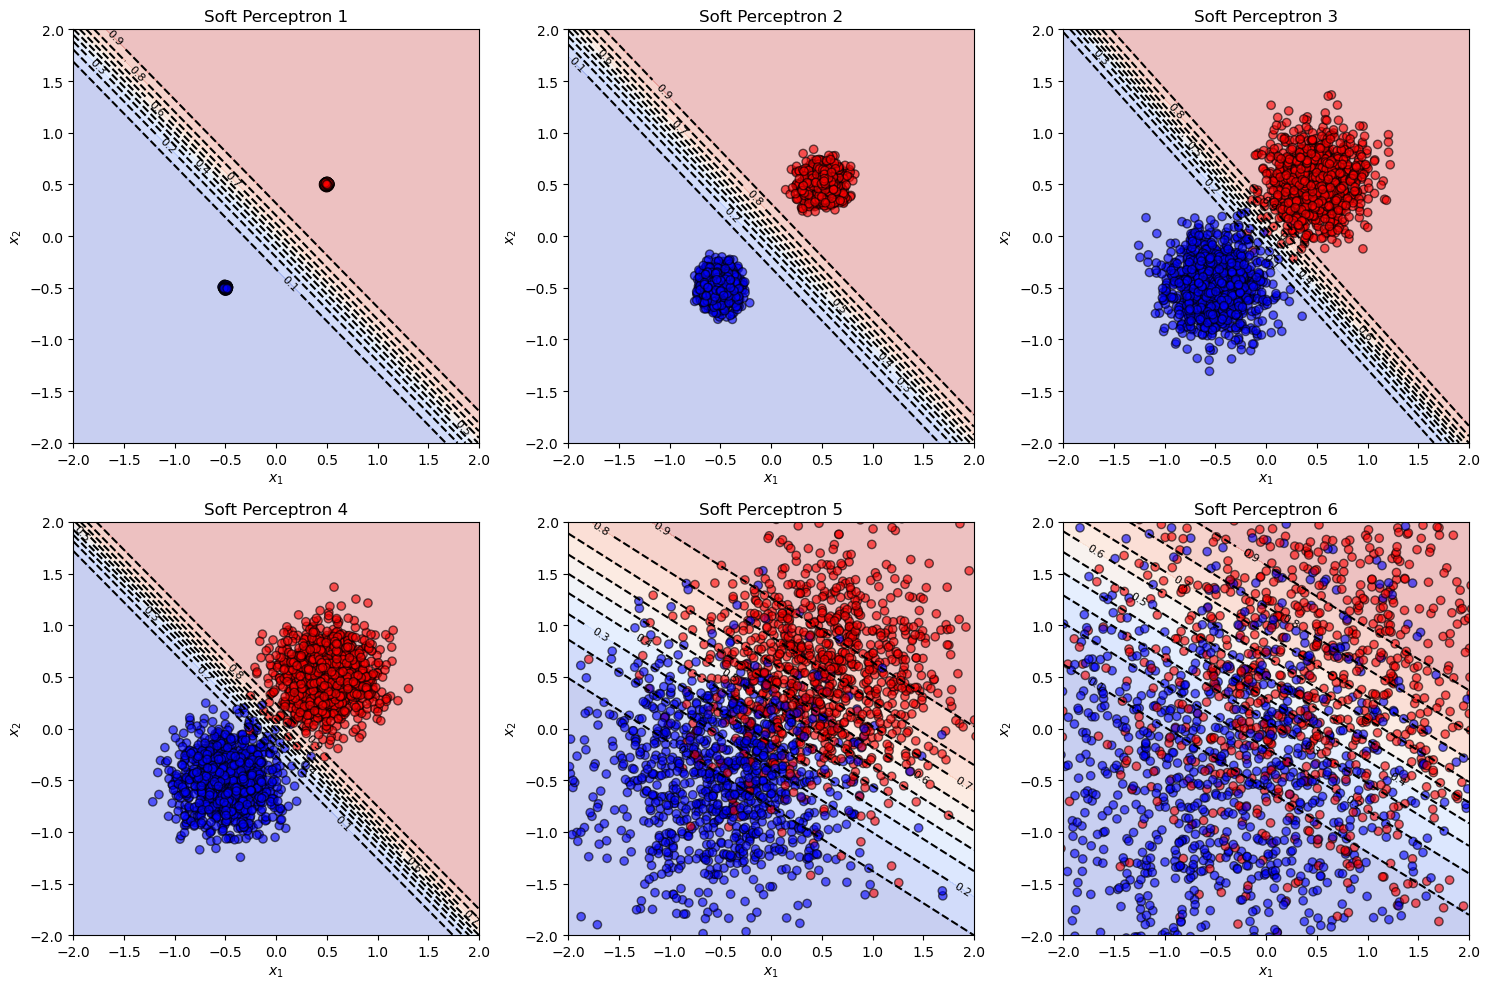

In [19]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = 2000

# First regime
F_1, y_1 = generate_dataset(n_samples=n_samples, sigma=0.01, mean=.5)
F_2, y_2 = generate_dataset(n_samples=n_samples, sigma=.1, mean=.5)
F_3, y_3 = generate_dataset(n_samples=n_samples, sigma=.25, mean=.5)

# Second regime
F_4, y_4 = generate_dataset(n_samples=n_samples, sigma=.25, mean=.5)
F_5, y_5 = generate_dataset(n_samples=n_samples, sigma=.65, mean=.5)
F_6, y_6 = generate_dataset(n_samples=n_samples, sigma=1.1, mean=.5)

regimes = [(F_1, y_1), (F_2, y_2), (F_3, y_3),
           (F_4, y_4), (F_5, y_5), (F_6, y_6)]

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.ravel()):
    # Train model
    p = SoftPerceptron(2)
    F, y = regimes[i]
    p.train(F, y)
    w, b = p.w, p.b
    
    # Grid
    x_min, x_max = -2, 2
    y_min, y_max = -2, 2
    # if i in [4,5]:
    #     x_min, x_max = -4, 4
    #     y_min, y_max = -4, 4
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = sigmoid(w[0] * xx + w[1] * yy + b)

    # Plot shaded probability regions
    ax.contourf(xx, yy, Z, 
                         levels=np.arange(0, 1.1, 0.1),alpha = 0.3,
                         cmap="coolwarm")

    # Equal-probability contour lines
    contours = ax.contour(xx, yy, Z,
                          levels=np.arange(0.1, 1.0, 0.1),
                           colors="k", linestyles="--")
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f")

    # Plot training points
    ax.scatter(F[:, 0], F[:, 1], c=y, cmap="bwr", edgecolors="k", alpha=0.6)

    ax.set_title(f"Soft Perceptron {i+1}")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

plt.tight_layout()
plt.show()


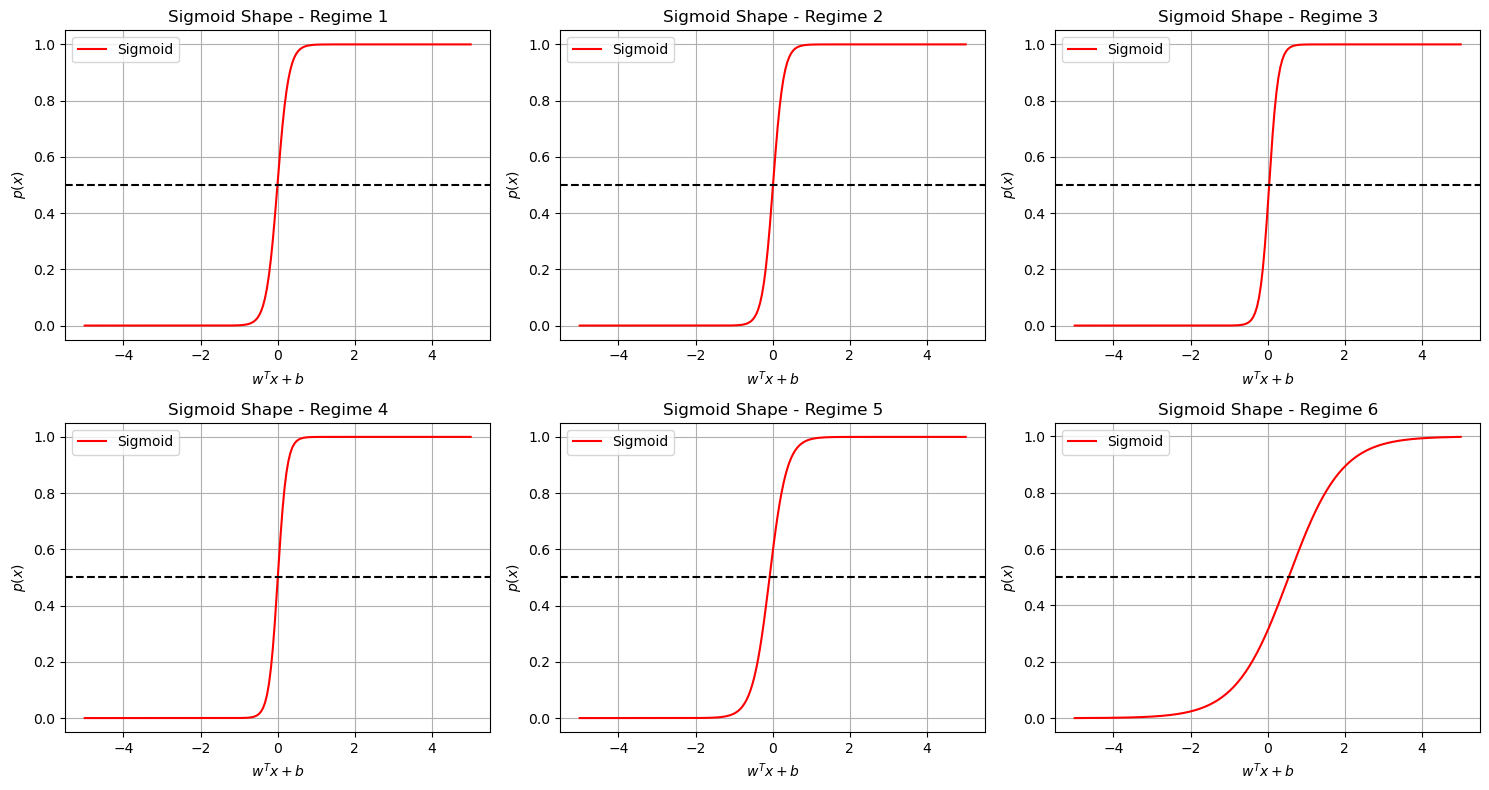

In [15]:
x_vals = np.linspace(-5, 5, 200)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in enumerate(axes.ravel()):
    F, y = regimes[i]
    p = SoftPerceptron(2)
    p.train(F, y)
    w, b = p.w, p.b

    # Evaluate sigmoid along a line (fix x2 = 0)
    z = w[0] * x_vals + b
    p_vals = sigmoid(z)

    ax.plot(x_vals, p_vals, 'r', label='Sigmoid')
    ax.axhline(0.5, color='k', linestyle='--')
    ax.set_title(f"Sigmoid Shape - Regime {i+1}")
    ax.set_xlabel("$w^T x + b$")
    ax.set_ylabel("$p(x)$")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


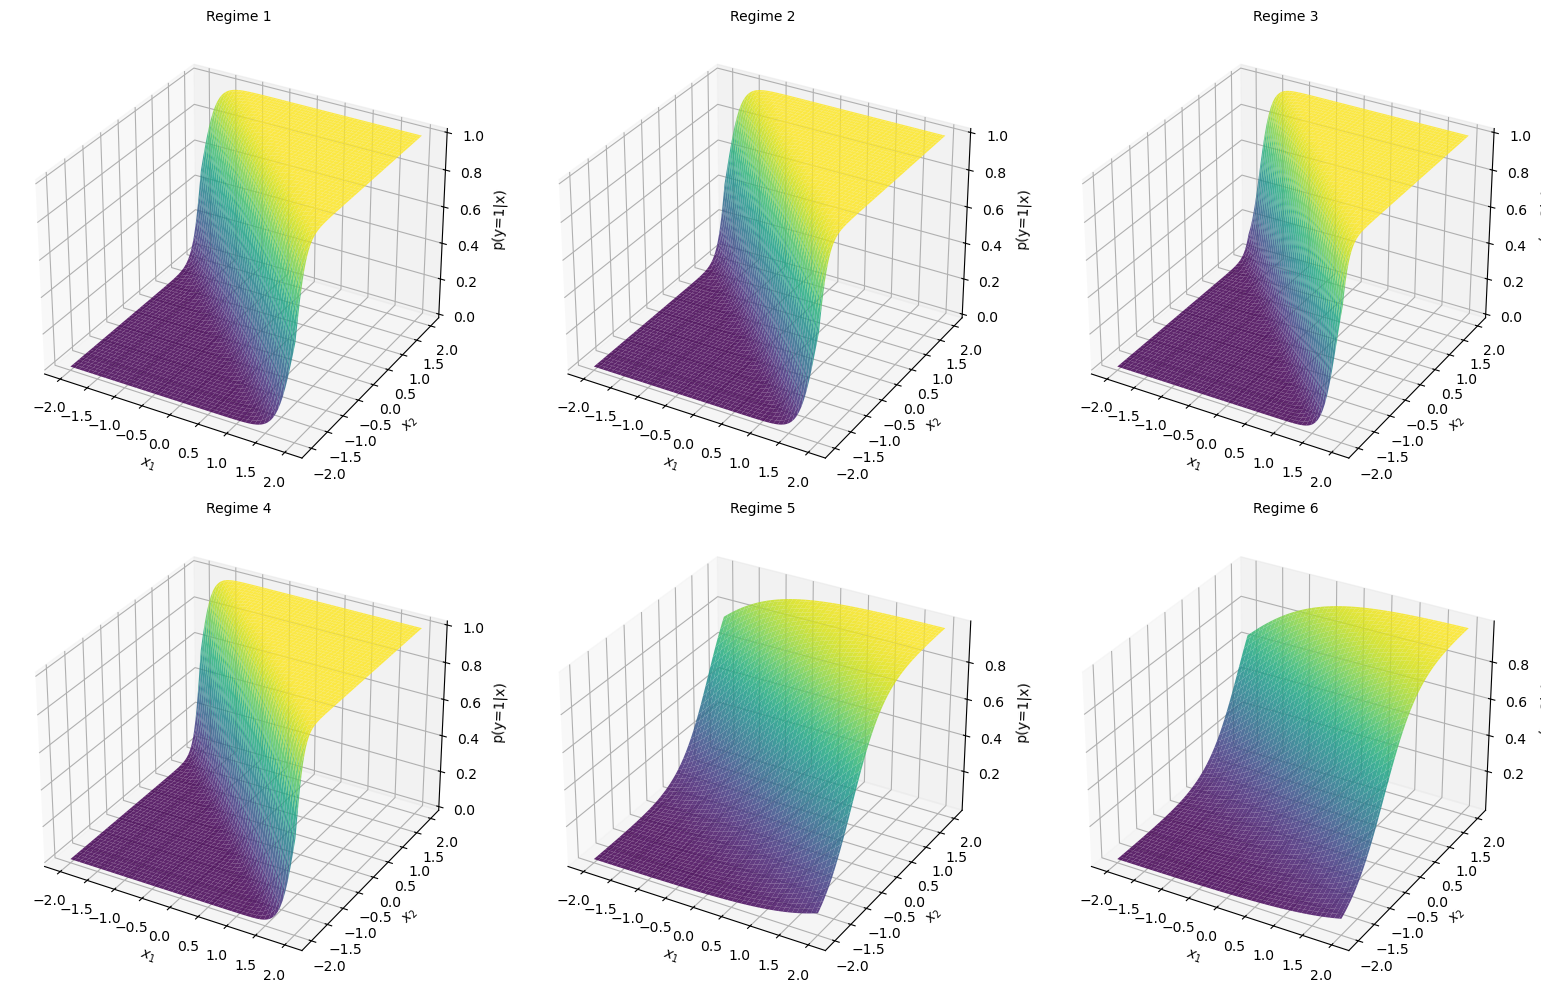

In [70]:
from mpl_toolkits.mplot3d import Axes3D


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

fig = plt.figure(figsize=(16, 10))

for i, (F, y) in enumerate(regimes):
    # Train model
    p = SoftPerceptron(2)
    p.train(F, y)
    w, b = p.w, p.b

    # Create 3D subplot
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')

    # Define grid for surface
    x_min, x_max = -2, 2
    y_min, y_max = -2, 2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Compute sigmoid surface
    Z = sigmoid(w[0] * xx + w[1] * yy + b)

    # Plot the surface
    ax.plot_surface(xx, yy, Z, cmap='viridis', alpha=0.85)
    ax.set_title(f"Regime {i+1}", fontsize=10)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("p(y=1|x)")

plt.tight_layout()
plt.show()


I have tried to visualize all the model outputs in three ways: Contour curves for all the regimes, using a single feature and a single weight component to show the shape of the sigmoid function and finally a 3D visualization of sigmoid function in a 2D feature input.

Answer to Q1:

 I have noticed that in regime 1, the sigmoid function is more steep as there is less variance. The datasets are clearly classified where they lay on other side of the decision boundary. The sigmoid surface is steep and sharp — it transitions quickly from 0 to 1. This happens because the data classes are well-separated with little overlap. The model is confident and can make clear, decisive predictions.

Answer to Q2:

The sigmoid function is now more flat. There is more overlap between the classes and the transition is smooth. d getting closer to the decision boundary as it becomes harder to classify sparsely distributed datasets. The points are clustered near the decision boundary as it becomes harder for the perceptron to classify them with more confidence.As variance increases, the sigmoid becomes flatter and smoother. The transition from 0 to 1 is more gradual because the data points overlap more, making classification less certain. The model’s output reflects higher uncertainty, producing probabilities closer to 0.5 in the overlap region.


As variance increases, the sigmoid’s slope decreases — the decision boundary softens, and the model becomes less confident due to noisier, overlapping data.                                                              

## Exercise 5

In this exercise, we will compare the performance of the soft perceptron with that of the hard perceptron from the previous assignment.  

You are provided with two datasets:  
- **A linearly separable dataset**  
- **A non-linearly separable dataset**  

Use these datasets to evaluate and compare the performance of both perceptrons.  

In [86]:
F_linsep, y_linsep = generate_dataset(n_samples=500, sigma=.3, mean=1)
F_nonlinsep, y_nonlinsep = generate_dataset(n_samples=500, sigma=1, mean=1)

# Split the dataset into a training and a test set
F_train_linsep, F_test_linsep, y_train_linsep, y_test_linsep = train_test_split(F_linsep, y_linsep, test_size=0.2, random_state=SEED)
F_train_nonlinsep, F_test_nonlinsep, y_train_nonlinsep, y_test_nonlinsep = train_test_split(F_nonlinsep, y_nonlinsep, test_size=0.2, random_state=SEED)

### Section 1 [1 Point]

Before training the perceptrons, you need to define the cross-entropy loss function, as covered in the lectures.

First, we define the total loss function as the average of the per-sample loss function over the dataset:
$$
\mathcal{L}(\boldsymbol{w}, \mathcal{D}) = \frac{1}{N} \sum_{n=1}^{N} L(\boldsymbol{w}, x_n, y_n)
$$

Then, we need to choose the per-sample loss function. For the soft perceptron, we use the binary cross-entropy loss. This is defined as:
$$
\mathbb{H}(y, \tilde{y}) = - y \log \tilde{y} - (1 - y) \log (1 - \tilde{y})    
$$
and therefore the per-sample loss is 
$$
\begin{align*}
L(\boldsymbol{w}, x, y) &= \mathbb{H}(y, \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x))) \\
                        &= y \text{softplus}(-\boldsymbol{w}^{\top} \boldsymbol{f}(x)) + (1-y) \text{softplus}(\boldsymbol{w}^{\top} \boldsymbol{f}(x))
\end{align*}
$$

In [87]:
def cross_entropy_loss(y_true, y_pred):
    eps = 1e-10
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


### Section 2 [1 Point]

The first task is to implement the `HardPerceptron` class, as you did in the previous assignment.  

Then:  
- Train the `HardPerceptron` on the training set of the linearly separable dataset.  
- Plot the decision boundary using the same training set.  

Finally, evaluate the cross-entropy loss on both the **training** and **test** sets.  

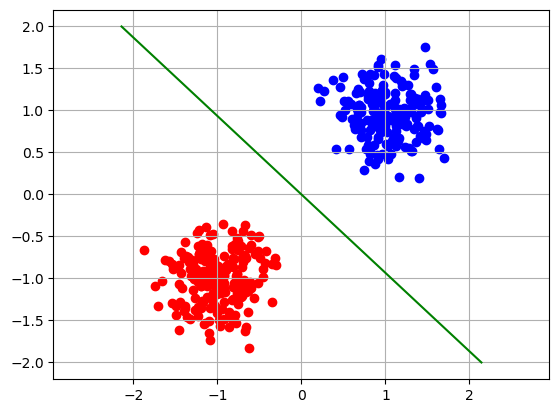

In [88]:
# TODO
class Perceptron:
    def __init__(self, n_features):
        # You can either include the bias term in the weights vector or not
        # but consider adapting the predict method accordingly
        self.w = np.zeros(n_features)
        self.b = 0

    def predict(self, f):
        # weight transpose times feature vector + bais > 0, return 1
        if((np.dot(self.w, f) + self.b) >= 0):
            return 1
        else:
            return 0
    def train(self, F, y):
        #new weight is old weight + (y - predict(self, F[i])) F[i] each feature or coordinate in this case
        for i in range(len(F)):
            self.w = self.w + (y[i] - self.predict(F[i])) * F[i]
            self.b = self.b + (y[i] - self.predict(F[i]))

HardPerceptron = Perceptron(2)
HardPerceptron.train(F_train_linsep,y_train_linsep)
f1 = []
f2 = [-2,2] # give random values for f2 to calculate f1 using w1f1 + w2f2 = -b, where we find the decision boundary 
for i in f2:
    f1.append((-HardPerceptron.b - (HardPerceptron.w[1]*i))/HardPerceptron.w[0])
plt.plot(f1,f2, color ="green")
plt.scatter(F_train_linsep[y_train_linsep == 0][:, 0], F_train_linsep[y_train_linsep == 0][:, 1], color='red')
plt.scatter(F_train_linsep[y_train_linsep == 1][:, 0], F_train_linsep[y_train_linsep == 1][:, 1], color='blue')
plt.grid()
plt.axis('equal')
plt.show()


In [89]:
#evaluate the ]the cross entrophy loss on both test and training sets
F_train_predict = np.array([HardPerceptron.predict(f) for f in F_train_linsep])
F_test_predict = np.array([HardPerceptron.predict(f) for f in F_test_linsep])

Hard_linsep_loss_training = cross_entropy_loss(F_train_predict, y_train_linsep)
Hard_linsep_loss_test = cross_entropy_loss(F_test_predict,y_test_linsep)
print("Hard Perceptron for Linearly Separable Data")
print("Cross Entropy Loss for Training: ", Hard_linsep_loss_training,"\nCross Entropy Loss for Testing: ", Hard_linsep_loss_test)

Hard Perceptron for Linearly Separable Data
Cross Entropy Loss for Training:  1.000000082790371e-10 
Cross Entropy Loss for Testing:  1.0000000827903707e-10


### Section 3 [2 Points]

In this section, repeat the same steps as in Section 2, but using the **soft perceptron**.  

**Note:** You do **not** need to re-implement the soft perceptron. Simply use the existing implementation.  

The steps are:  
- Train the soft perceptron on the training set of the linearly separable dataset.  
- Plot the decision boundary using the same training set.  
- Evaluate the cross-entropy loss on both the **training** and **test** sets.  


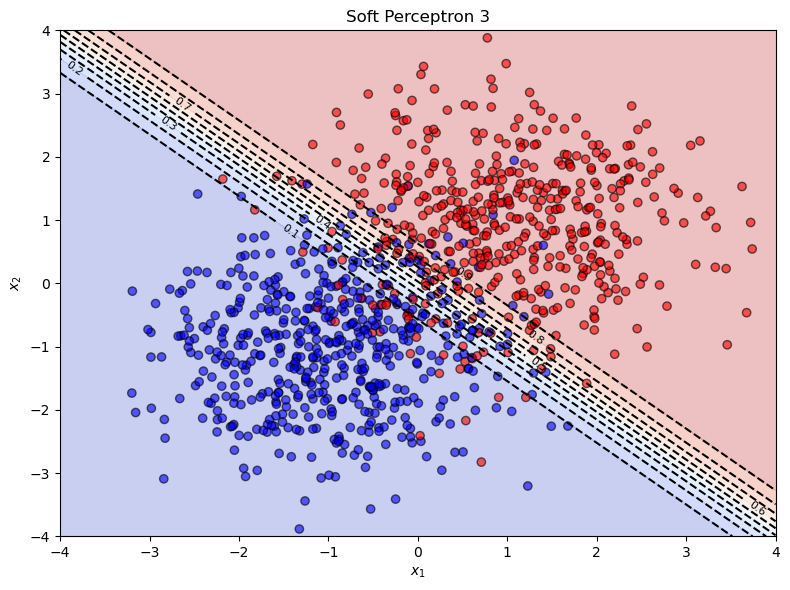

In [90]:
# TODO
NewSoftPerceptron = SoftPerceptron(2)
NewSoftPerceptron.train(F_train_linsep,y_train_linsep)
x_min, x_max = -4, 4
y_min, y_max = -4, 4
w, b = NewSoftPerceptron.w, NewSoftPerceptron.b

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
Z = sigmoid(w[0] * xx + w[1] * yy + b)

# Plot shaded probability regions
ax.contourf(xx, yy, Z, 
                        levels=np.arange(0, 1.1, 0.1),alpha = 0.3,
                        cmap="coolwarm")

# Equal-probability contour lines
contours = ax.contour(xx, yy, Z,
                        levels=np.arange(0.1, 1.0, 0.1),
                        colors="k", linestyles="--")
ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f")

# Plot training points
ax.scatter(F[:, 0], F[:, 1], c=y, cmap="bwr", edgecolors="k", alpha=0.6)

ax.set_title(f"Soft Perceptron {i+1}")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

plt.tight_layout()
plt.show()


In [91]:
#evaluate the ]the cross entrophy loss on both test and training sets
F_train_predict = np.array([NewSoftPerceptron.predict(f) for f in F_train_linsep])
F_test_predict = np.array([NewSoftPerceptron.predict(f) for f in F_test_linsep])

Soft_linsep_loss_training = cross_entropy_loss(F_train_predict, y_train_linsep)
Soft_linsep_loss_test = cross_entropy_loss(F_test_predict,y_test_linsep)
print("Soft Perceptron for Linearly Separable Data")
print("Cross Entropy Loss for Training: ", Soft_linsep_loss_training,"\nCross Entropy Loss for Testing: ", Soft_linsep_loss_test)

Soft Perceptron for Linearly Separable Data
Cross Entropy Loss for Training:  0.05092192706327937 
Cross Entropy Loss for Testing:  0.06354115096535497


### Section 4 [3 Points]

Repeat the procedures from **Sections 2 and 3**, but this time using the **non-linearly separable dataset**.  

Once completed, answer the following questions:

- Which perceptron achieves a lower loss on the linearly separable dataset? Why?
- Which perceptron achieves a lower loss on the non-linearly separable dataset? Why?

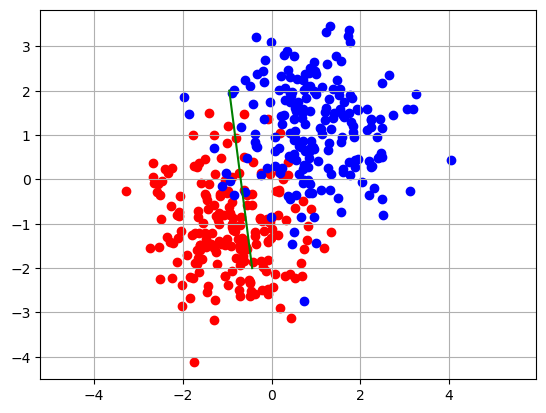

In [92]:
# TODO
HardPerceptron2 = Perceptron(2)
HardPerceptron2.train(F_train_nonlinsep,y_train_nonlinsep)
f1 = []
f2 = [-2,2] # give random values for f2 to calculate f1 using w1f1 + w2f2 = -b, where we find the decision boundary 
for i in f2:
    f1.append((-HardPerceptron2.b - (HardPerceptron2.w[1]*i))/HardPerceptron2.w[0])
plt.plot(f1,f2, color ="green")
plt.scatter(F_train_nonlinsep[y_train_nonlinsep == 0][:, 0], F_train_nonlinsep[y_train_nonlinsep == 0][:, 1], color='red')
plt.scatter(F_train_nonlinsep[y_train_nonlinsep == 1][:, 0], F_train_nonlinsep[y_train_nonlinsep == 1][:, 1], color='blue')
plt.grid()
plt.axis('equal')
plt.show()

In [93]:
#evaluate the ]the cross entropy loss on both test and training sets
F_train_predict = np.array([HardPerceptron2.predict(f) for f in F_train_nonlinsep])
F_test_predict = np.array([HardPerceptron2.predict(f) for f in F_test_nonlinsep])

Hard_nonlinsep_loss_training = cross_entropy_loss(F_train_predict, y_train_nonlinsep)
Hard_nonlinsep_loss_test = cross_entropy_loss(F_test_predict,y_test_nonlinsep)
print("Hard Perceptron for Non Linearly Separable Data")
print("Cross Entropy Loss for Training: ", Hard_nonlinsep_loss_training,"\nCross Entropy Loss for Testing: ", Hard_nonlinsep_loss_test)

Hard Perceptron for Non Linearly Separable Data
Cross Entropy Loss for Training:  4.029523911374124 
Cross Entropy Loss for Testing:  5.295945710653691


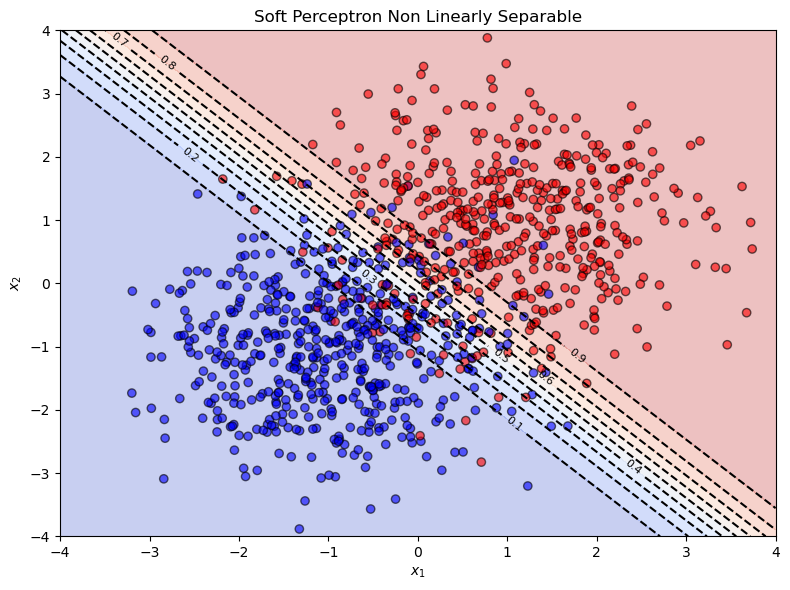

In [94]:
# TODO
NewSoftPerceptron2 = SoftPerceptron(2)
NewSoftPerceptron2.train(F_train_nonlinsep,y_train_nonlinsep)
x_min, x_max = -4, 4
y_min, y_max = -4, 4
w, b = NewSoftPerceptron2.w, NewSoftPerceptron2.b

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
Z = sigmoid(w[0] * xx + w[1] * yy + b)

# Plot shaded probability regions
ax.contourf(xx, yy, Z, 
                        levels=np.arange(0, 1.1, 0.1),alpha = 0.3,
                        cmap="coolwarm")

# Equal-probability contour lines
contours = ax.contour(xx, yy, Z,
                        levels=np.arange(0.1, 1.0, 0.1),
                        colors="k", linestyles="--")
ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f")

# Plot training points
ax.scatter(F[:, 0], F[:, 1], c=y, cmap="bwr", edgecolors="k", alpha=0.6)

ax.set_title(f"Soft Perceptron Non Linearly Separable")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

plt.tight_layout()
plt.show()


In [95]:
#evaluate the ]the cross entrophy loss on both test and training sets
F_train_predict = np.array([NewSoftPerceptron2.predict(f) for f in F_train_nonlinsep])
F_test_predict = np.array([NewSoftPerceptron2.predict(f) for f in F_test_nonlinsep])

Soft_nonlinsep_loss_training = cross_entropy_loss(F_train_predict, y_train_nonlinsep)
Soft_nonlinsep_loss_test = cross_entropy_loss(F_test_predict,y_test_nonlinsep)
print("Soft Perceptron for Non Linearly Separable Data")
print("Cross Entropy Loss for Training: ", Soft_nonlinsep_loss_training,"\nCross Entropy Loss for Testing: ", Soft_nonlinsep_loss_test)

Soft Perceptron for Non Linearly Separable Data
Cross Entropy Loss for Training:  2.243335764072688 
Cross Entropy Loss for Testing:  2.6167095172093036


In [96]:

print(f"{'Cross-Entropy Loss Summary':^65}")
print("=" * 65)
print(f"{'Model':<20}{'Training Loss':<20}{'Testing Loss':<20}")
print("-" * 65)
print(f"{'Hard Linsep':<20}{Hard_linsep_loss_training:<20.6f}{Hard_linsep_loss_test:<20.6f}")
print(f"{'Hard Nonlinsep':<20}{Hard_nonlinsep_loss_training:<20.6f}{Hard_nonlinsep_loss_test:<20.6f}")
print(f"{'Soft Linsep':<20}{Soft_linsep_loss_training:<20.6f}{Soft_linsep_loss_test:<20.6f}")
print(f"{'Soft Nonlinsep':<20}{Soft_nonlinsep_loss_training:<20.6f}{Soft_nonlinsep_loss_test:<20.6f}")
print("=" * 65)


                   Cross-Entropy Loss Summary                    
Model               Training Loss       Testing Loss        
-----------------------------------------------------------------
Hard Linsep         0.000000            0.000000            
Hard Nonlinsep      4.029524            5.295946            
Soft Linsep         0.050922            0.063541            
Soft Nonlinsep      2.243336            2.616710            


Answer to Q1:

For linearly separable dataset, the hard perceptron has a very low cross entropy as the data sets were on either side of the decision boundary. 

Answer to Q2:

For the non linearly separable dataset, our soft perceptron has a lower loss since unlike the hard perceptron it gives the probability of a set belonging to a class which reduces loss when the datasets are overlapping. The hard perceptron has to commit to the either class, so it won't be able to converge. Therefore, for non linearly separable dataset, where inputs are on either side of the decision boundary, the soft perceptron has a lower loss than the hard perceptron. 